# Groupe non officiel 1
# Livrable 3 - Traitement d'images

|Auteur|Centre|
|---|---|
|BOUCLIER Clément|Aix-en-Provence|
|LEDRU Alexandre|Aix-en-Provence|
|RIVIERE LUCAS|Aix-en-Provence|
|ROMANO Sébastien|Aix-en-Provence|

## Rappel du sujet
Le but est de créer un réseau de neurones qui génère des légendes pour des images en s'appuyant sur le dataset dataset MS COCO.
Le réseau sera composé de deux parties:
 - la partie CNN qui encode les images en un représentation interne,
 - et le partie RNN utilise cette représentation pour prédire l'annotation séquence par séquence.

Avant l'entraînement du modèle les images sont prétraitées par un CNN pré-entrainé pour la classification.

Le livrable contient :
- Un descriptif sur le pré-traitements de images et du texte.
- L'architecture complète du réseau utilisé pour le captioning explicitant le type de CNN utilisé pour les prétraitements.
- Une analyse sous forme de courbes des performances du réseau pendant l'entrainement.
- Quelques exemples pour les tests.

## Analyse à effectuer

Le but de cette étape va être le suivant :
- Prétraiter les données
- Classifier les données par un CNN
- Prédire les annotations via un RNN

Afin d'obtenir notre réseau de neurones qui génère des légendes pour des photographies. Nous allons combiner le CNN et le RNN.
Le RNN est branché sur l'avant-dernière couche de notre CNN afin de récupérer le traitement préalablement fait pour effectuer la prédiction d'annotation.

## Import des différentes bibliothèques

In [33]:
import keras
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

## Téléchargement et préparation du jeu de données MS-COCO

Nous allons utiliser le jeu de données issue de [MS-COCO dataset](http://cocodataset.org/#home) pour entrainer notre modèle.
Le jeu de données contient plus de 82 000 images, chacune d'entre elles possède au moins 5 annotations de légende différentes.

Le code ci-dessous télécharge et prépare les jeux de données.

**Attention: Jeu de données conséquent**. Temps de téléchargement très important !

all_picture permet de selectionner si l'on veut utiliser les 82 000 images ou non. Si on prends les 82 000, il faut compter 20mn pour 1 epochs. (à voir selon les performances du pc).

In [34]:
all_picture = False

In [35]:
# Téléchargement des fichiers d'annotation de captionning
annotation_folder = '../DatasetL3/annotations/'
if not os.path.exists(annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = '../DatasetL3/annotations/captions_train2014.json'
  os.remove(annotation_zip)
else:
    annotation_file = "../DatasetL3/annotations/captions_train2014.json"

# Téléchargement des images
image_folder = '../DatasetL3/train2014/'
if not os.path.exists(image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = image_folder
  os.remove(image_zip)
else:
  PATH = image_folder

## Optional: limit the size of the training set
To speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train your model. Choosing to use more data would result in improved captioning quality.

In [36]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [37]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [38]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

if all_picture :
    train_image_paths = image_paths
    print(len(train_image_paths))
else:
    train_image_paths = image_paths[:6000]
    print(len(train_image_paths))

6000


In [39]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> A man sits in the back of a blue boat while a lady sitting toward the middle paddles while some ducks swim off to the side. <end>


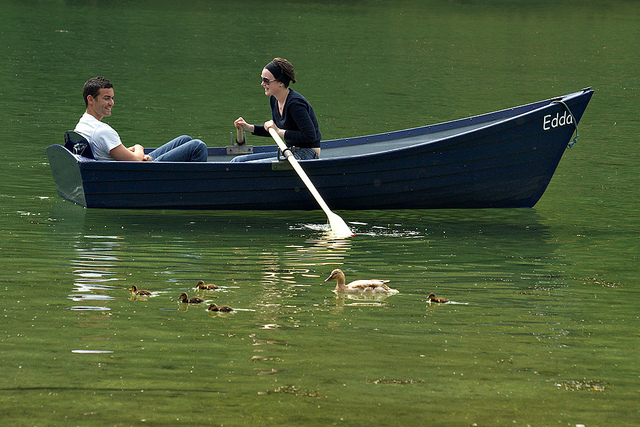

In [40]:
print(train_captions[0])
Image.open(img_name_vector[0])

## Preprocess the images using MobileNetV2
Ensuite, nous allons utiliser MobileNetV2 pré-entrainé pour classifier les images. Nous allons extraires les features de la dernière couche.
On redimensionne les images dans le MobileNetV2 :
* Redimensionnement des images en 299px par 299px
* [Preprocess the images](https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html)

In [41]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    return img, image_path

## Initialize MobileNetV2 and load the pretrained Imagenet weights
Maintenant nous allons créer un tf.keras model ou la dernier couche d'output dans MobileNetV2 architecture.
Le shape de la sortie de la couche est ```4x4x1280```. On utilise la dernière couche de convolution car on rajoute l'Attention.

In [42]:
image_model = tf.keras.applications.MobileNetV2(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

## Recupération des features extraitent du MobileNetV2

Nous allons pré-traiter chaque image avec MobileNetV2 et stocker les sorties sur notre disques. On notera que charger les sorties dans notre RAM permettra un traitement plus rapide. Au moment de l'écriture, il faut savoir que l'on peut dépasser les 12 giga de mémoire.

Le traitement peut prendre environ 10 minutes de traitement sur GPU (varie en fonction des performances de l'ordinateur).

Pour voir la barre de progression de traitement sur le GPU, on utilise :

In [43]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

## Prétraitement et tokénisation des légendes

* Premièrement, on va récupérer les légendes. Cela nous donne un vocabulaire de tous les mots uniques dans les données (par exemple, "surf", "football", etc.).
* Par la suite, on limite la taille des vocabulaire à 5 000 words pour économiser la mémoire.

In [44]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [45]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [46]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [47]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [48]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [49]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## Split des données en deux dossiers training et testing

In [50]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [51]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24011, 24011, 6004, 6004)

## Création d'un tf.data dataset pour le training

Nos images et légendes sont enfin prêtes. Nous allons créer un dataset pour entrainer notre model.

In [52]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 2048
attention_features_shape = 81

In [53]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [54]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model
Pour effectuer notre modèle, nous allons utiliser des customs class avec `Attention`, `CNN_Encoder` & `RNN_Decoder` afin de tuner nos modèles et de pouvoir récupérer les différentes couches finales.

In [55]:
import ModelCustom
encoder = ModelCustom.CNN_Encoder(embedding_dim)
decoder = ModelCustom.RNN_Decoder(embedding_dim, units, vocab_size)

In [56]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

Checkpoint

In [57]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  #restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

Afin de faire le training, on utilise le `tf.function` qui va nous permettre de récupérer la sortie de notre CNN et de le placer en entrée de notre RNN afin d'effectuer l'analyse et la prédiction.

In [58]:
loss_plot = []

In [59]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [60]:
EPOCHS = 30

for epoch in range(EPOCHS): #start_epoch,
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if (epoch+1) % 5 == 0:
        ckpt_manager.save()
        encoder.save(f'../final/model/L3_encoder.epoch{epoch+1}-loss{total_loss/ num_steps:.2f}', save_format='tf')
        decoder.save(f'../final/model/L3_decoder.epoch{epoch+1}-loss{total_loss/ num_steps:.2f}', save_format='tf')
        encoder.save_weights(f'../final/model/Weights_L3_encoder.epoch{epoch+1}-loss{total_loss/ num_steps:.2f}')
        decoder.save_weights(f'../final/model/Weights_L3_decoder.epoch{epoch+1}-loss{total_loss/ num_steps:.2f}')
    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.9343
Epoch 1 Batch 100 Loss 1.0793
Epoch 1 Batch 200 Loss 0.9647
Epoch 1 Batch 300 Loss 0.9232
Epoch 1 Loss 0.996404
Time taken for 1 epoch 180.00 sec

Epoch 2 Batch 0 Loss 0.8819
Epoch 2 Batch 100 Loss 0.7514
Epoch 2 Batch 200 Loss 0.7632
Epoch 2 Batch 300 Loss 0.8125
Epoch 2 Loss 0.766084
Time taken for 1 epoch 93.83 sec

Epoch 3 Batch 0 Loss 0.7072
Epoch 3 Batch 100 Loss 0.6335
Epoch 3 Batch 200 Loss 0.7287
Epoch 3 Batch 300 Loss 0.7262
Epoch 3 Loss 0.682801
Time taken for 1 epoch 104.13 sec

Epoch 4 Batch 0 Loss 0.6207
Epoch 4 Batch 100 Loss 0.6571
Epoch 4 Batch 200 Loss 0.6009
Epoch 4 Batch 300 Loss 0.6042
Epoch 4 Loss 0.625283
Time taken for 1 epoch 99.65 sec

Epoch 5 Batch 0 Loss 0.5955
Epoch 5 Batch 100 Loss 0.6112
Epoch 5 Batch 200 Loss 0.5854
Epoch 5 Batch 300 Loss 0.5866
INFO:tensorflow:Assets written to: ../final/model/L3_encoder.epoch5-loss0.58\assets


INFO:tensorflow:Assets written to: ../final/model/L3_decoder.epoch5-loss0.58\assets


INFO:tensorflow:Assets written to: ../final/model/L3_decoder.epoch5-loss0.58\assets


Epoch 5 Loss 0.579368
Time taken for 1 epoch 109.21 sec

Epoch 6 Batch 0 Loss 0.5086
Epoch 6 Batch 100 Loss 0.5333
Epoch 6 Batch 200 Loss 0.5195
Epoch 6 Batch 300 Loss 0.5324
Epoch 6 Loss 0.540726
Time taken for 1 epoch 103.82 sec

Epoch 7 Batch 0 Loss 0.5586
Epoch 7 Batch 100 Loss 0.5058
Epoch 7 Batch 200 Loss 0.5453
Epoch 7 Batch 300 Loss 0.4695
Epoch 7 Loss 0.505559
Time taken for 1 epoch 100.88 sec

Epoch 8 Batch 0 Loss 0.4730
Epoch 8 Batch 100 Loss 0.5387
Epoch 8 Batch 200 Loss 0.4977
Epoch 8 Batch 300 Loss 0.4895
Epoch 8 Loss 0.473062
Time taken for 1 epoch 96.85 sec

Epoch 9 Batch 0 Loss 0.4336
Epoch 9 Batch 100 Loss 0.4696
Epoch 9 Batch 200 Loss 0.4251
Epoch 9 Batch 300 Loss 0.4385
Epoch 9 Loss 0.442058
Time taken for 1 epoch 96.01 sec

Epoch 10 Batch 0 Loss 0.3831
Epoch 10 Batch 100 Loss 0.4530
Epoch 10 Batch 200 Loss 0.4202
Epoch 10 Batch 300 Loss 0.4059
INFO:tensorflow:Assets written to: ../final/model/L3_encoder.epoch10-loss0.41\assets


INFO:tensorflow:Assets written to: ../final/model/L3_encoder.epoch10-loss0.41\assets


INFO:tensorflow:Assets written to: ../final/model/L3_decoder.epoch10-loss0.41\assets


INFO:tensorflow:Assets written to: ../final/model/L3_decoder.epoch10-loss0.41\assets


Epoch 10 Loss 0.413571
Time taken for 1 epoch 107.22 sec

Epoch 11 Batch 0 Loss 0.3640
Epoch 11 Batch 100 Loss 0.4114
Epoch 11 Batch 200 Loss 0.3815
Epoch 11 Batch 300 Loss 0.4093
Epoch 11 Loss 0.387751
Time taken for 1 epoch 96.52 sec

Epoch 12 Batch 0 Loss 0.3565
Epoch 12 Batch 100 Loss 0.3632
Epoch 12 Batch 200 Loss 0.3703
Epoch 12 Batch 300 Loss 0.3529
Epoch 12 Loss 0.363126
Time taken for 1 epoch 99.01 sec

Epoch 13 Batch 0 Loss 0.3282
Epoch 13 Batch 100 Loss 0.3420
Epoch 13 Batch 200 Loss 0.3422
Epoch 13 Batch 300 Loss 0.3683
Epoch 13 Loss 0.339857
Time taken for 1 epoch 100.44 sec

Epoch 14 Batch 0 Loss 0.3440
Epoch 14 Batch 100 Loss 0.3206
Epoch 14 Batch 200 Loss 0.3315
Epoch 14 Batch 300 Loss 0.2950
Epoch 14 Loss 0.318533
Time taken for 1 epoch 98.27 sec

Epoch 15 Batch 0 Loss 0.2711
Epoch 15 Batch 100 Loss 0.2990
Epoch 15 Batch 200 Loss 0.2840
Epoch 15 Batch 300 Loss 0.3243
INFO:tensorflow:Assets written to: ../final/model/L3_encoder.epoch15-loss0.30\assets


INFO:tensorflow:Assets written to: ../final/model/L3_encoder.epoch15-loss0.30\assets


INFO:tensorflow:Assets written to: ../final/model/L3_decoder.epoch15-loss0.30\assets


INFO:tensorflow:Assets written to: ../final/model/L3_decoder.epoch15-loss0.30\assets


Epoch 15 Loss 0.299706
Time taken for 1 epoch 108.80 sec

Epoch 16 Batch 0 Loss 0.3097
Epoch 16 Batch 100 Loss 0.2805
Epoch 16 Batch 200 Loss 0.2802
Epoch 16 Batch 300 Loss 0.3168
Epoch 16 Loss 0.282227
Time taken for 1 epoch 96.08 sec

Epoch 17 Batch 0 Loss 0.2818
Epoch 17 Batch 100 Loss 0.2677
Epoch 17 Batch 200 Loss 0.2564
Epoch 17 Batch 300 Loss 0.2577
Epoch 17 Loss 0.267650
Time taken for 1 epoch 96.38 sec

Epoch 18 Batch 0 Loss 0.2898
Epoch 18 Batch 100 Loss 0.2742
Epoch 18 Batch 200 Loss 0.2486
Epoch 18 Batch 300 Loss 0.2458
Epoch 18 Loss 0.253702
Time taken for 1 epoch 96.07 sec

Epoch 19 Batch 0 Loss 0.2521
Epoch 19 Batch 100 Loss 0.2445
Epoch 19 Batch 200 Loss 0.2353
Epoch 19 Batch 300 Loss 0.2468
Epoch 19 Loss 0.239415
Time taken for 1 epoch 96.14 sec

Epoch 20 Batch 0 Loss 0.2370
Epoch 20 Batch 100 Loss 0.2672
Epoch 20 Batch 200 Loss 0.2239
Epoch 20 Batch 300 Loss 0.2543
INFO:tensorflow:Assets written to: ../final/model/L3_encoder.epoch20-loss0.23\assets


INFO:tensorflow:Assets written to: ../final/model/L3_encoder.epoch20-loss0.23\assets


INFO:tensorflow:Assets written to: ../final/model/L3_decoder.epoch20-loss0.23\assets


INFO:tensorflow:Assets written to: ../final/model/L3_decoder.epoch20-loss0.23\assets


Epoch 20 Loss 0.228701
Time taken for 1 epoch 105.14 sec

Epoch 21 Batch 0 Loss 0.2237
Epoch 21 Batch 100 Loss 0.2151
Epoch 21 Batch 200 Loss 0.2175
Epoch 21 Batch 300 Loss 0.2345
Epoch 21 Loss 0.218618
Time taken for 1 epoch 94.26 sec

Epoch 22 Batch 0 Loss 0.2151
Epoch 22 Batch 100 Loss 0.2095
Epoch 22 Batch 200 Loss 0.2080
Epoch 22 Batch 300 Loss 0.2018
Epoch 22 Loss 0.209437
Time taken for 1 epoch 102.21 sec

Epoch 23 Batch 0 Loss 0.1971
Epoch 23 Batch 100 Loss 0.2079
Epoch 23 Batch 200 Loss 0.1957
Epoch 23 Batch 300 Loss 0.1943
Epoch 23 Loss 0.201108
Time taken for 1 epoch 96.77 sec

Epoch 24 Batch 0 Loss 0.1923
Epoch 24 Batch 100 Loss 0.1826
Epoch 24 Batch 200 Loss 0.1860
Epoch 24 Batch 300 Loss 0.2153
Epoch 24 Loss 0.193657
Time taken for 1 epoch 96.45 sec

Epoch 25 Batch 0 Loss 0.1831
Epoch 25 Batch 100 Loss 0.1770
Epoch 25 Batch 200 Loss 0.1923
Epoch 25 Batch 300 Loss 0.1854
INFO:tensorflow:Assets written to: ../final/model/L3_encoder.epoch25-loss0.19\assets


INFO:tensorflow:Assets written to: ../final/model/L3_encoder.epoch25-loss0.19\assets


INFO:tensorflow:Assets written to: ../final/model/L3_decoder.epoch25-loss0.19\assets


INFO:tensorflow:Assets written to: ../final/model/L3_decoder.epoch25-loss0.19\assets


Epoch 25 Loss 0.187258
Time taken for 1 epoch 106.61 sec

Epoch 26 Batch 0 Loss 0.1763
Epoch 26 Batch 100 Loss 0.1898
Epoch 26 Batch 200 Loss 0.1745
Epoch 26 Batch 300 Loss 0.1774
Epoch 26 Loss 0.182375
Time taken for 1 epoch 96.35 sec

Epoch 27 Batch 0 Loss 0.1824
Epoch 27 Batch 100 Loss 0.1908
Epoch 27 Batch 200 Loss 0.1823
Epoch 27 Batch 300 Loss 0.1792
Epoch 27 Loss 0.175929
Time taken for 1 epoch 96.57 sec

Epoch 28 Batch 0 Loss 0.1756
Epoch 28 Batch 100 Loss 0.1650
Epoch 28 Batch 200 Loss 0.1621
Epoch 28 Batch 300 Loss 0.1812
Epoch 28 Loss 0.172266
Time taken for 1 epoch 96.97 sec

Epoch 29 Batch 0 Loss 0.1619
Epoch 29 Batch 100 Loss 0.1610
Epoch 29 Batch 200 Loss 0.1679
Epoch 29 Batch 300 Loss 0.1732
Epoch 29 Loss 0.166709
Time taken for 1 epoch 100.53 sec

Epoch 30 Batch 0 Loss 0.1617
Epoch 30 Batch 100 Loss 0.1628
Epoch 30 Batch 200 Loss 0.1647
Epoch 30 Batch 300 Loss 0.1698
INFO:tensorflow:Assets written to: ../final/model/L3_encoder.epoch30-loss0.16\assets


INFO:tensorflow:Assets written to: ../final/model/L3_encoder.epoch30-loss0.16\assets


INFO:tensorflow:Assets written to: ../final/model/L3_decoder.epoch30-loss0.16\assets


INFO:tensorflow:Assets written to: ../final/model/L3_decoder.epoch30-loss0.16\assets


Epoch 30 Loss 0.162742
Time taken for 1 epoch 109.69 sec



In [61]:
encoder.save('../model/L3_encoder_Full',save_format='tf')
decoder.save('../model/L3_decoder_Full',save_format='tf')

INFO:tensorflow:Assets written to: ../model/L3_encoder_Full\assets


INFO:tensorflow:Assets written to: ../model/L3_encoder_Full\assets


INFO:tensorflow:Assets written to: ../model/L3_decoder_Full\assets


INFO:tensorflow:Assets written to: ../model/L3_decoder_Full\assets


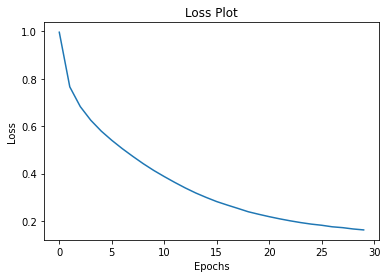

In [62]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

La fonction d'évaluation est similaire à la boucle d'apprentissage. L'entrée du décodeur à chaque pas de temps est constituée de ses prédictions précédentes, de l'état caché et de la sortie du codeur.
* Arrêtez de prédire lorsque le modèle prédit le jeton de fin.
* Et stocker les poids d'attention pour chaque étape de temps.

In [63]:
def evaluate(image,encoder,decoder):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [64]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a <unk> with several picnic tables and <unk> surrounding <end>
Prediction Caption: a living room at a bench at a table <end>


d:\document\ecole\cesi\annee 5\projet_datascience_a5\venv\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


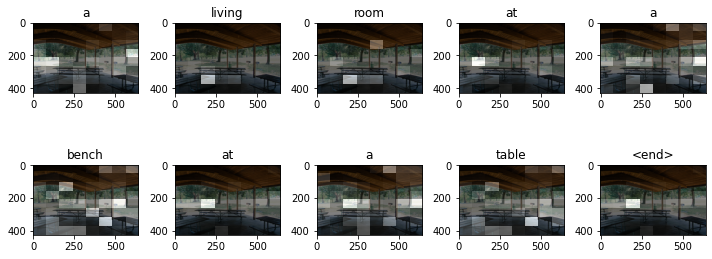

In [65]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image,encoder,decoder)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

## Essaye sur nos images
Ci-dessous, nous avons une méthode qui nous permet de légender les images avec le modèle que l'on vient d'entrainer.

Prediction Caption: a man on a surfboard <end>


d:\document\ecole\cesi\annee 5\projet_datascience_a5\venv\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


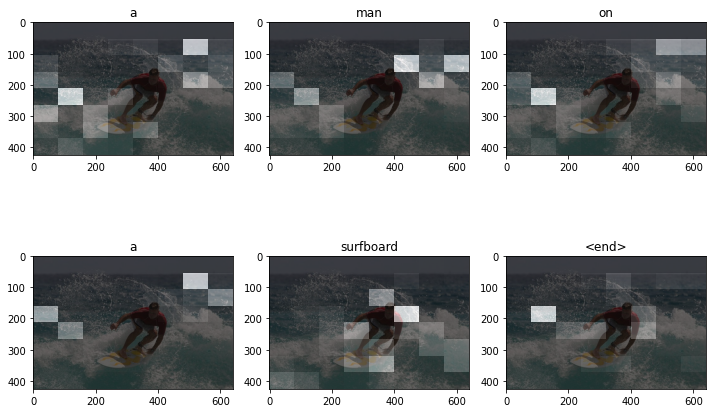

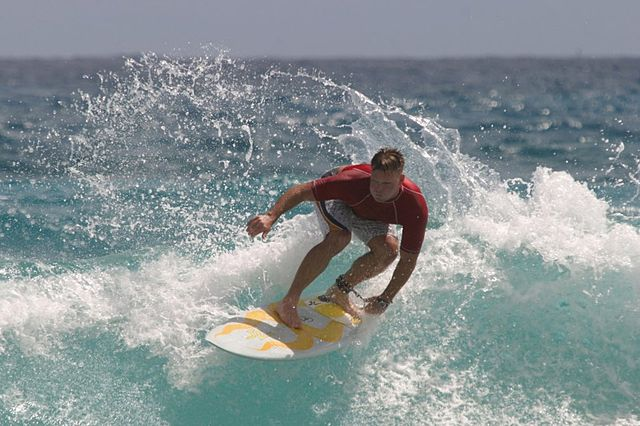

In [66]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path,encoder,decoder)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)